In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
%matplotlib inline
plt.style.use('Solarize_Light2')

In [2]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, classification_report, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

In [3]:
df = pd.read_csv('german_credit_data.csv', index_col=[0])

In [4]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


In [6]:
df.isna().sum()/df.shape[0]*100

Age                  0.0
Sex                  0.0
Job                  0.0
Housing              0.0
Saving accounts     18.3
Checking account    39.4
Credit amount        0.0
Duration             0.0
Purpose              0.0
dtype: float64

In [7]:
df.duplicated().sum()

0

In [8]:
df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64

In [9]:
df['Job'].value_counts()

Job
2    630
1    200
3    148
0     22
Name: count, dtype: int64

In [10]:
df['Saving accounts'].value_counts()

Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64

In [11]:
df['Checking account'].value_counts()

Checking account
little      274
moderate    269
rich         63
Name: count, dtype: int64

In [12]:
profile = ProfileReport(df, title="Profiling Report")
#profile.to_file('report.html')
#profile.to_notebook_iframe()

In [13]:
num_features = ['Age', 'Job', 'Credit amount', 'Duration']
label_features = ['Saving accounts', 'Checking account']
cat_features = ['Sex', 'Housing', 'Purpose']

In [14]:
df_pair = df[num_features + label_features].copy()
df_pair['Saving accounts'] = df_pair['Saving accounts'].map({'little': 1, 'moderate': 2 ,'quite rich': 3, 'rich': 4})
df_pair['Checking account'] = df_pair['Checking account'].map({'little': 1, 'moderate': 2, 'rich': 3})

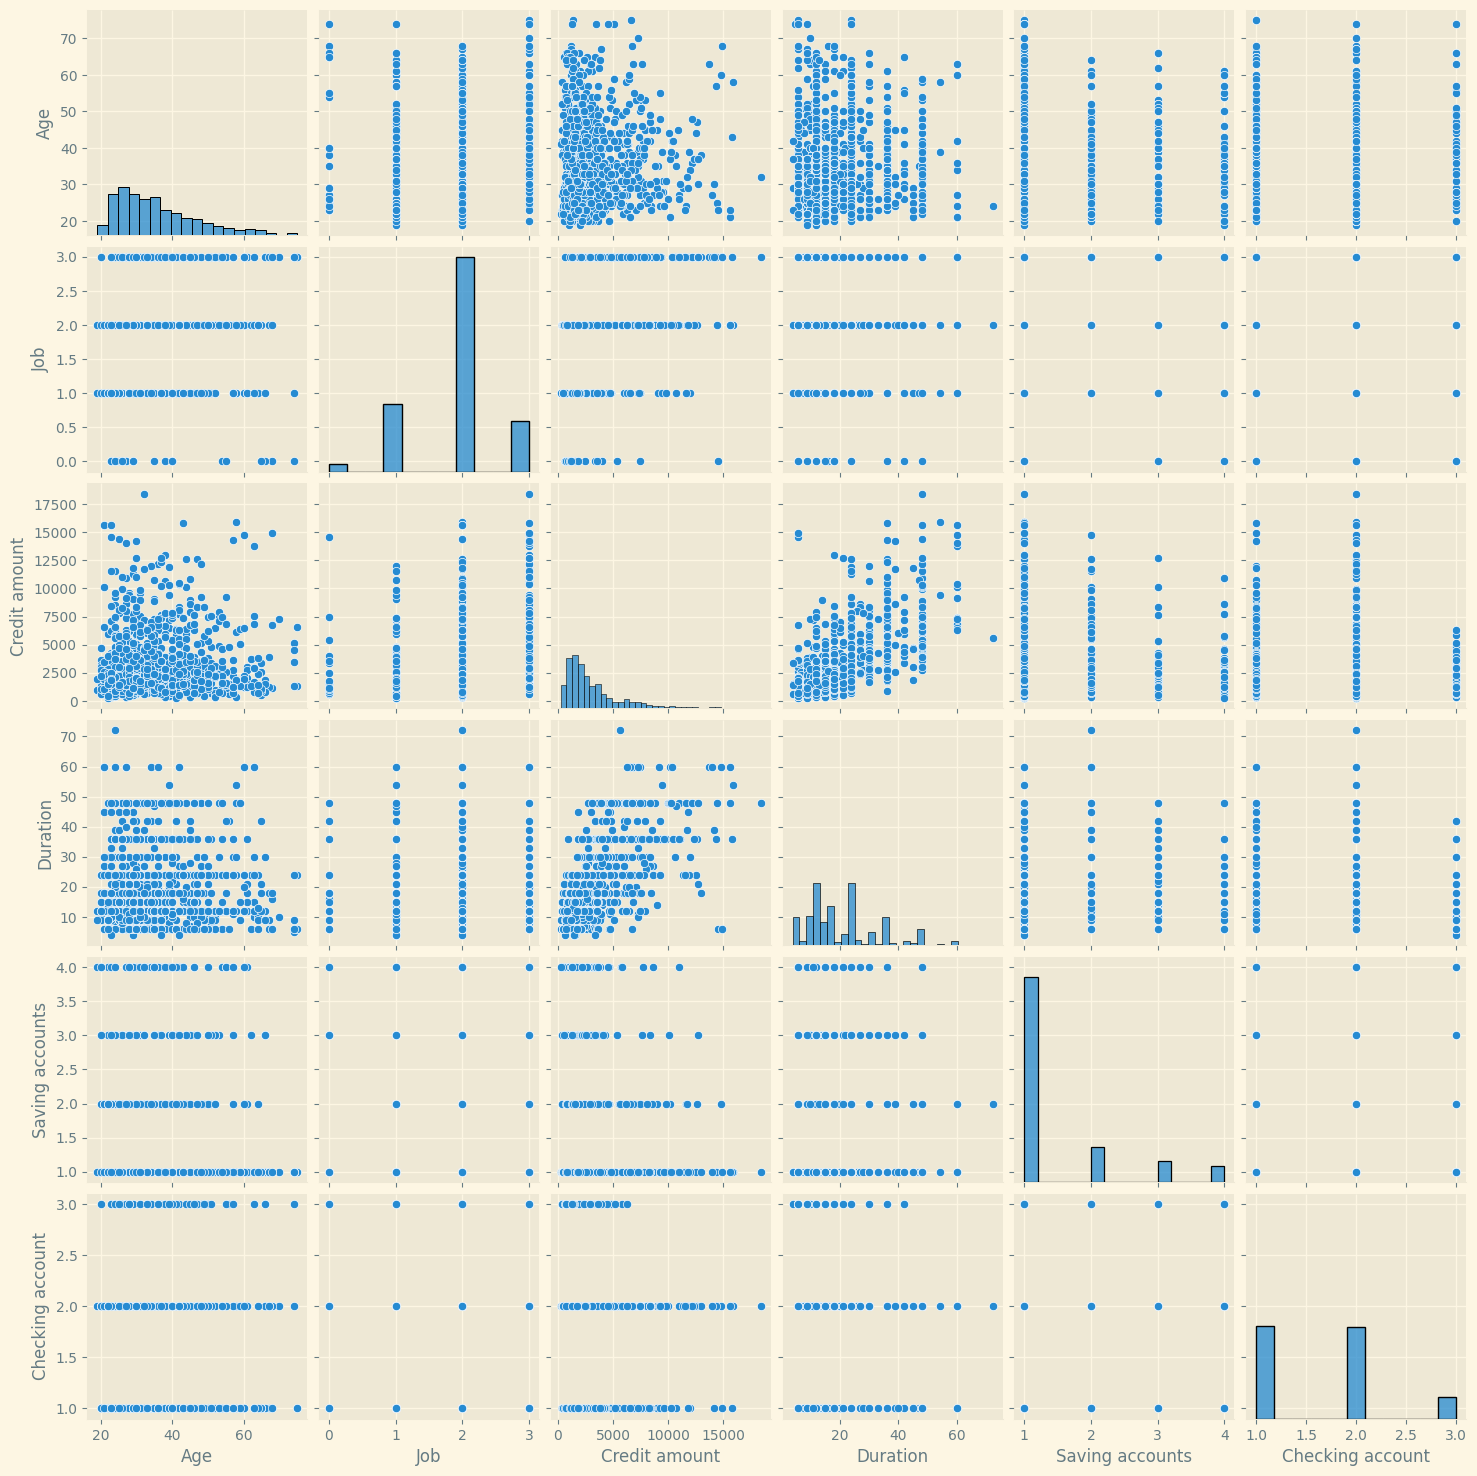

In [15]:
sns.pairplot(df_pair)
plt.show()

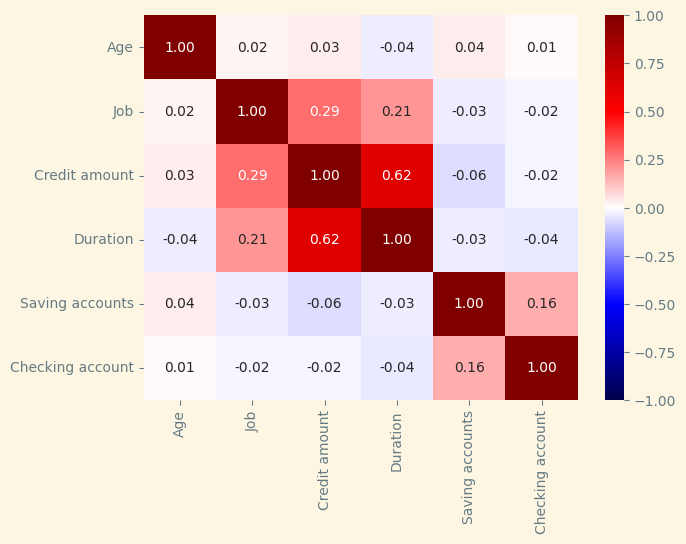

In [16]:
plt.figure(figsize=(7, 5))
sns.heatmap(df_pair.corr(), cbar=True, cmap='seismic', annot = True, vmin=-1, vmax=1, center= 0, fmt='.2f')
plt.show()

1) Пропуски в признаках 'Saving accounts' и 'Checking account', 18 и 39 процентов. Пропуски первого заменим средними, для второго попробуем заменить средним или вообще выкинуть признак. Также для признаков применим LabelEncoder, так как имеется порядковая зависимость, так как little меньше чем moderate и тд 
2) Дубликатов нет
3) Проверили распределение и корреляцию, зависимостей не найдено
4) Для категориальный признаков 'Sex', 'Housing', 'Purpose' применим OneHot
5) Для числовых признаков применим StandartScaler, чтобы одни признаки не преобладали над другими за счет бОльших абсолютных значений

In [17]:
def label_encode_saving_accounts(X: pd.DataFrame, y=None)->pd.DataFrame:
    for c in X.columns:
        X[c] = X.loc[:,c].map({'little': 1, 'moderate': 2 ,'quite rich': 3, 'rich': 4})
    return X

In [18]:
def label_encode_checking_account(X: pd.DataFrame, y=None)->pd.DataFrame:
    for c in X.columns:
        X[c] = X.loc[:,c].map({'little': 1, 'moderate': 2 ,'rich': 3})
    return X

In [19]:
label_sa_transformer = Pipeline(steps=[
    ('label_sa', FunctionTransformer(label_encode_saving_accounts)),
    ('imputer', SimpleImputer(strategy='median')),
    #('imputer', SimpleImputer(fill_value=0)),
    ('scaler', StandardScaler()),
    ])

label_ca_transformer = Pipeline(steps=[
    ('label_ca', FunctionTransformer(label_encode_checking_account)),
    ('imputer', SimpleImputer(strategy='median')),
    #('imputer', SimpleImputer(fill_value=0)),
    ('scaler', StandardScaler()),
    ])

cat_features_transformer = Pipeline(steps=[
    ('oh', OneHotEncoder(handle_unknown='ignore')),
    ])

num_features_transformer = Pipeline(steps=[
    ('SS', StandardScaler()),
    ])

data_transformer = ColumnTransformer(transformers=[
    ('saving accounts', label_sa_transformer, ['Saving accounts']),
    ('checking accounts', label_ca_transformer, ['Checking account']),
    ('cat_features', cat_features_transformer, cat_features),
    ('num_features', num_features_transformer, num_features),
])

preprocessor = Pipeline(steps=[('data_transformer', data_transformer)])

In [20]:
preprocessor

Pipeline(steps=[('data_transformer',
                 ColumnTransformer(transformers=[('saving accounts',
                                                  Pipeline(steps=[('label_sa',
                                                                   FunctionTransformer(func=<function label_encode_saving_accounts at 0x7f11686d1da0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Saving accounts']),
                                                 ('checking accounts',
                                                  Pipeline(steps=[('label_ca',
                                                                   FunctionTra...ncode_checking_account at 0x7f116a03e520>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Checking account']),
                                                 ('cat_features',
                                                  Pipeline(steps=[('oh',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Housing',
                                                   'Purpose']),
                                                 ('num_features',
                                                  Pipeline(steps=[('SS',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration'])]))])

In [21]:
data = preprocessor.fit_transform(df)
data.shape

(1000, 19)

In [22]:
#data_dr = TSNE(n_components=2, random_state=42).fit_transform(data);
#data_dr = PCA(n_components=2, random_state=42).fit_transform(data);
data_dr = umap.UMAP(n_components=2, random_state=42).fit_transform(data);

/home/evgeny/.pyenv/versions/3.11.8/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


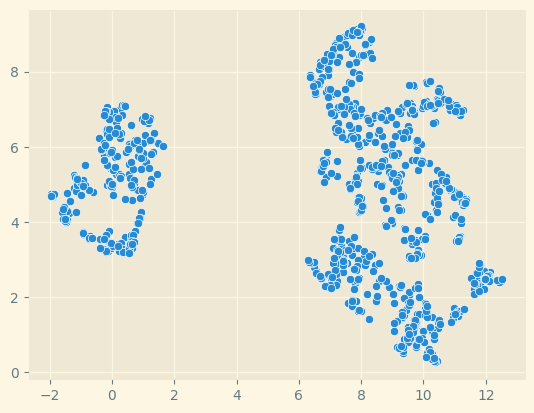

In [23]:
sns.scatterplot(x=data_dr[:,0], y=data_dr[:,1]);

In [24]:
inertia: list = []
silhouette: list = []
Elbow: list = []

for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10).fit(data)
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)
    sil_score = silhouette_score(data, kmeans.labels_)
    silhouette.append(sil_score)

for i in range(1, len(inertia)-1):
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    Elbow.append(Di)

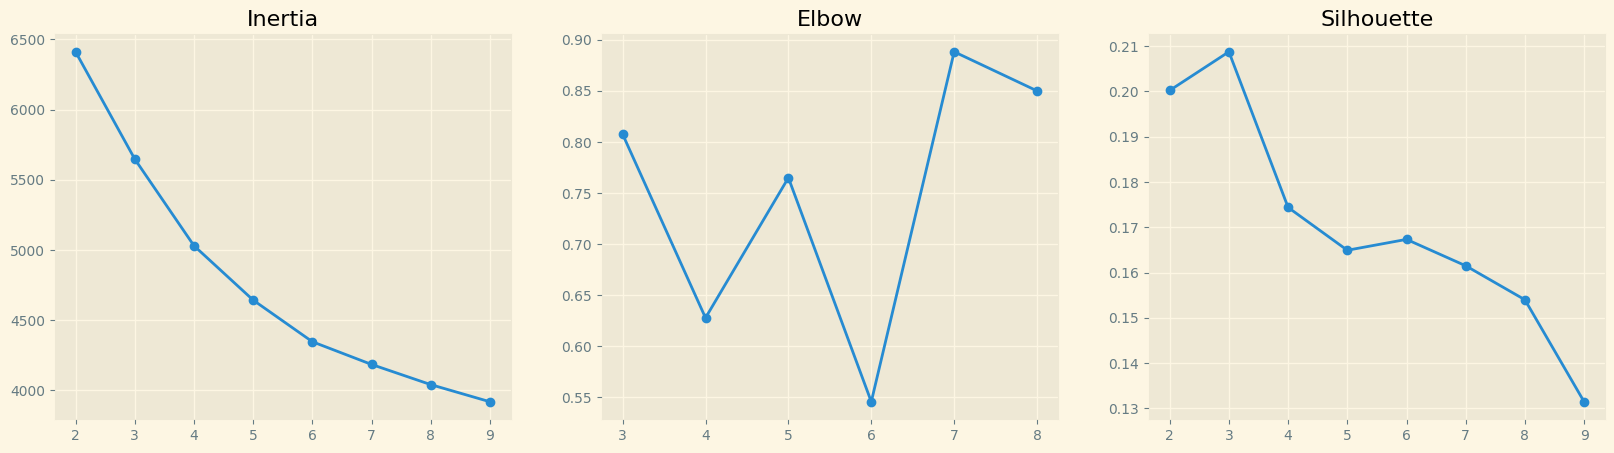

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
ax1.plot(range(2, len(inertia)+2), inertia, marker='o');
ax1.set_title('Inertia')
ax2.plot(range(3,len(Elbow)+3), Elbow, marker='o');
ax2.set_title('Elbow')
ax3.plot(range(2,len(silhouette)+2), silhouette, marker='o');
ax3.set_title('Silhouette')
plt.show()


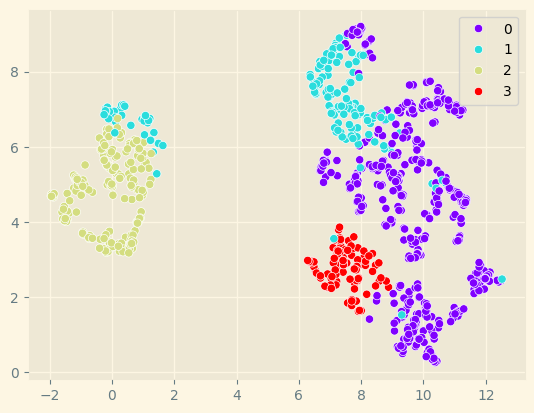

In [26]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(data)
labels = kmeans.labels_
sns.scatterplot(x=data_dr[:,0], y=data_dr[:,1], hue=labels, palette='rainbow');

In [27]:
df['kmeans_4clusters'] = pd.Series(labels)

Иерархическая кластеризация

In [28]:
silhouette: list = []
Elbow: list = []

for i in range(2,10):
    agg = AgglomerativeClustering(n_clusters=i).fit(data)
    sil_score = silhouette_score(data, agg.labels_)
    silhouette.append(sil_score)


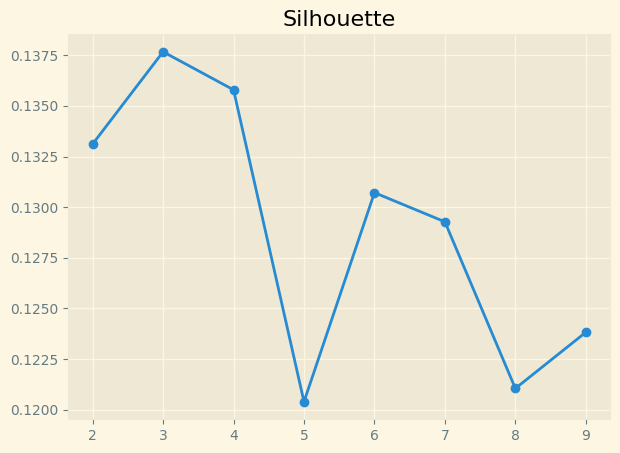

In [29]:
fig, ax1 = plt.subplots(1, 1, figsize=(7,5))
ax1.plot(range(2,len(silhouette)+2), silhouette, marker='o');
ax1.set_title('Silhouette')
plt.show()

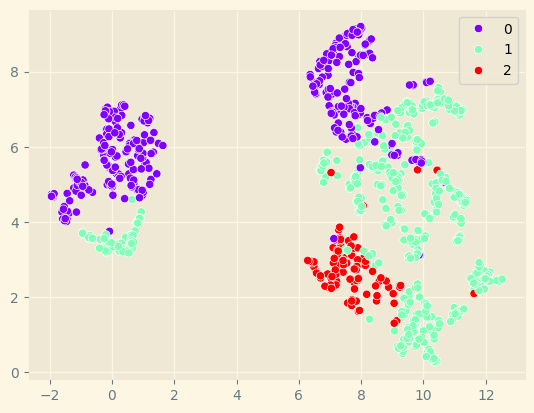

In [30]:
agg = AgglomerativeClustering(n_clusters=3).fit(data)
labels = agg.labels_
sns.scatterplot(x=data_dr[:,0], y=data_dr[:,1], hue=labels, palette='rainbow');

In [31]:
df['agg_3clusters'] = pd.Series(labels)

DBScan

In [32]:
silhouette = []
clusters = []
eps_range = np.arange(0.1,2,0.1)
for i in eps_range:
    dbscan = DBSCAN(eps=i).fit(data)
    labels = dbscan.labels_
    uniq_labels = np.unique(labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        score = silhouette_score(data, labels)
    else:
        score = 0
    silhouette.append(score)
    clusters.append(n_clusters)

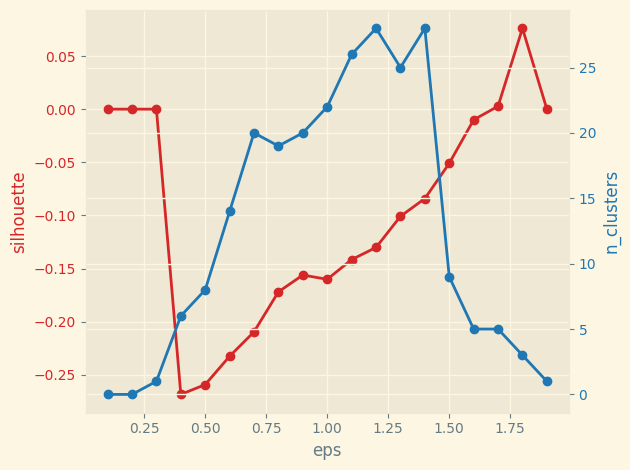

In [33]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(eps_range, silhouette, marker='o', color=color)
ax1.set_xlabel('eps')
ax1.set_ylabel('silhouette', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(eps_range, clusters, marker='o', color=color)
ax2.set_ylabel('n_clusters', color=color)  
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

кластеров: 3


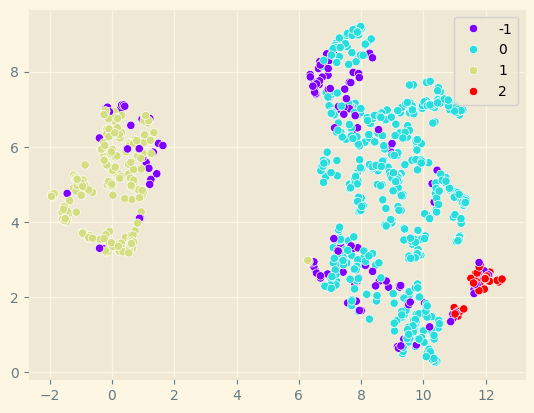

In [34]:
dbscan = DBSCAN(eps=1.8, min_samples=5).fit(data)
labels = dbscan.labels_
uniq_labels = np.unique(labels)
n_clusters = len(uniq_labels[uniq_labels != -1])
print(f'кластеров: {n_clusters}')
sns.scatterplot(x=data_dr[:,0], y=data_dr[:,1], hue=labels, palette='rainbow');

In [35]:
df['dbscan_3clusters'] = pd.Series(labels)

Интерпритация.
Как видно из визуализаций, некторые кластера(как, например, "0" от DBScan) сильно размазаны, вероятно, теряется часть данных при снижении размерности, так как обучаемся на полных данных, а отрисовываем только на сжатых.
Но попробуем найти некотрые закономерности в полученных кластерах.

In [37]:
df.groupby(['kmeans_4clusters'])[num_features].mean().round(1)

,Age,Job,Credit amount,Duration
kmeans_4clusters,,,,
0,35.0,1.8,2223.9,16.2
1,37.0,2.3,7692.5,38.4
2,34.7,1.8,2338.0,18.0
3,37.1,1.8,2223.5,17.5


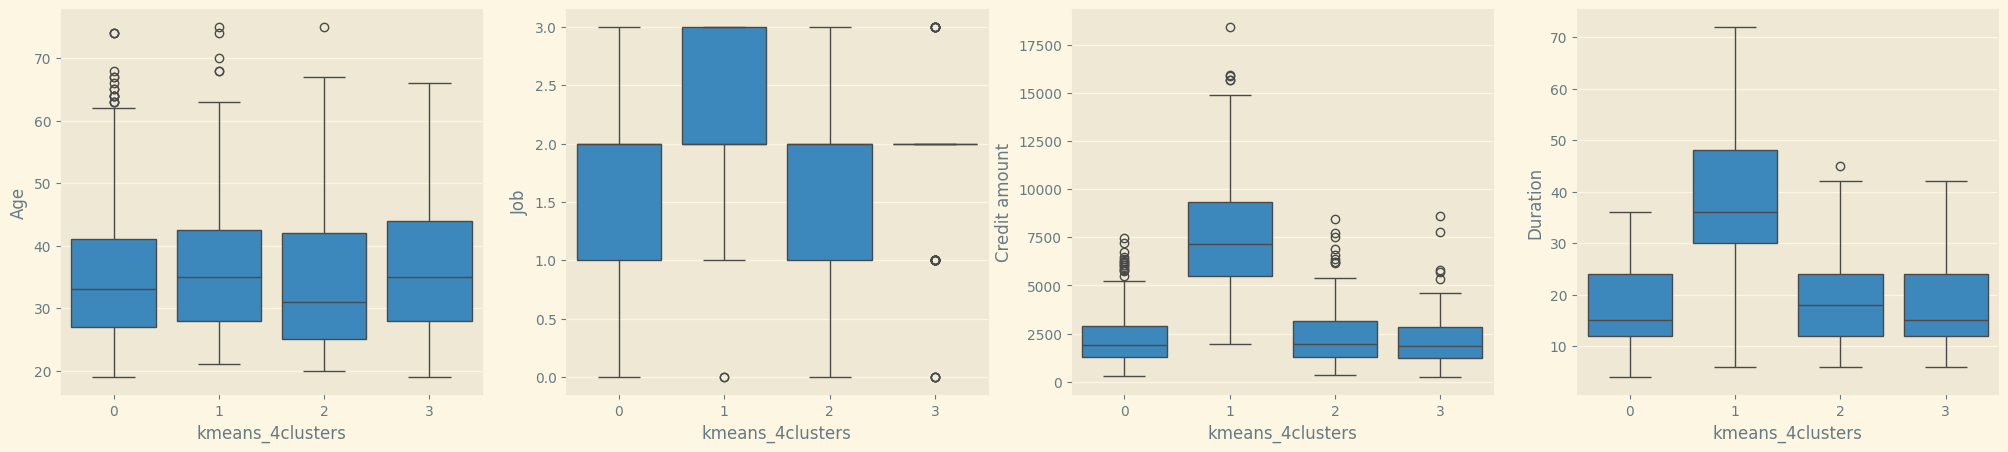

In [52]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(25,5))
sns.boxplot(ax=ax0, data=df, x='kmeans_4clusters', y='Age')
sns.boxplot(ax=ax1, data=df, x='kmeans_4clusters', y='Job')
sns.boxplot(ax=ax2, data=df, x='kmeans_4clusters', y='Credit amount')
sns.boxplot(ax=ax3, data=df, x='kmeans_4clusters', y='Duration')
plt.show()

In [41]:
df.groupby(['agg_3clusters'])[num_features].mean().round(1)

,Age,Job,Credit amount,Duration
agg_3clusters,,,,
0,36.6,2.3,4948.3,27.3
1,34.4,1.6,2262.6,16.8
2,37.3,1.8,2179.5,17.8


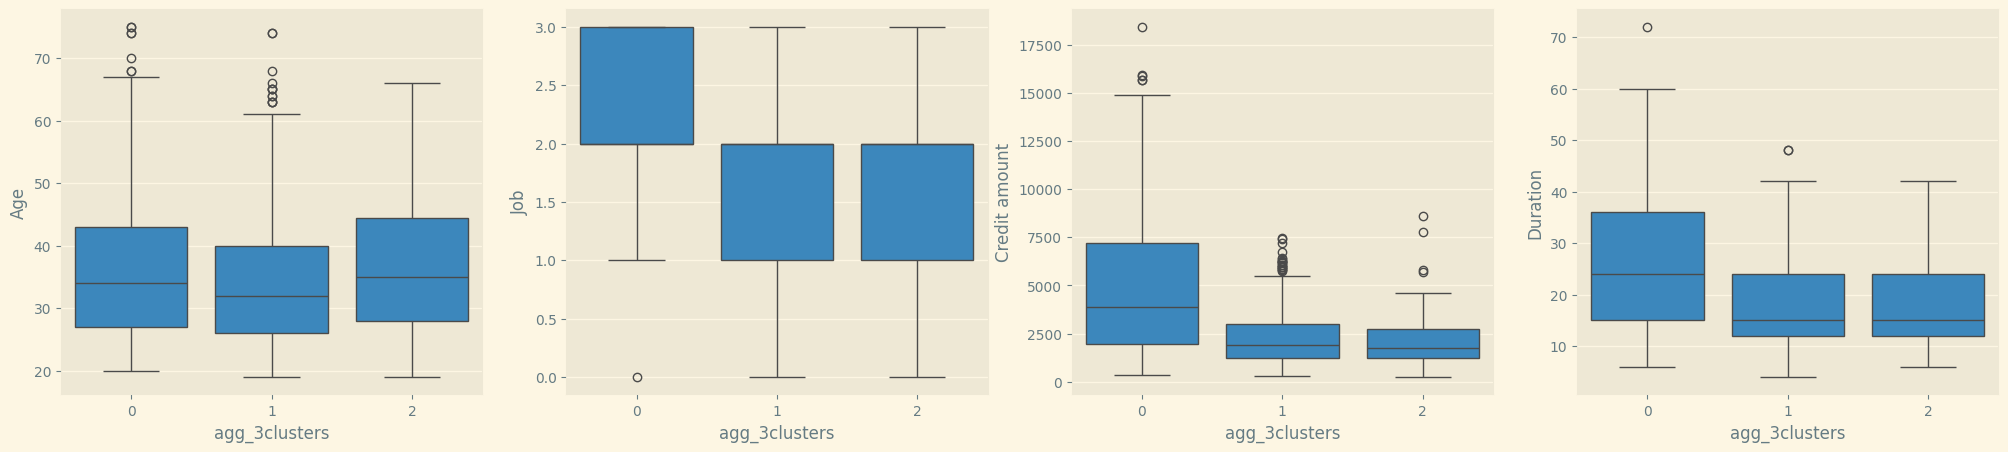

In [53]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(25,5))
sns.boxplot(ax=ax0, data=df, x='agg_3clusters', y='Age')
sns.boxplot(ax=ax1, data=df, x='agg_3clusters', y='Job')
sns.boxplot(ax=ax2, data=df, x='agg_3clusters', y='Credit amount')
sns.boxplot(ax=ax3, data=df, x='agg_3clusters', y='Duration')
plt.show()

In [42]:
df.groupby(['dbscan_3clusters'])[num_features].mean().round(1)

,Age,Job,Credit amount,Duration
dbscan_3clusters,,,,
-1,41.6,1.9,5695.3,27.6
0,34.9,1.9,2849.8,19.4
1,33.8,1.8,2804.8,20.5
2,32.1,1.8,2659.1,18.3


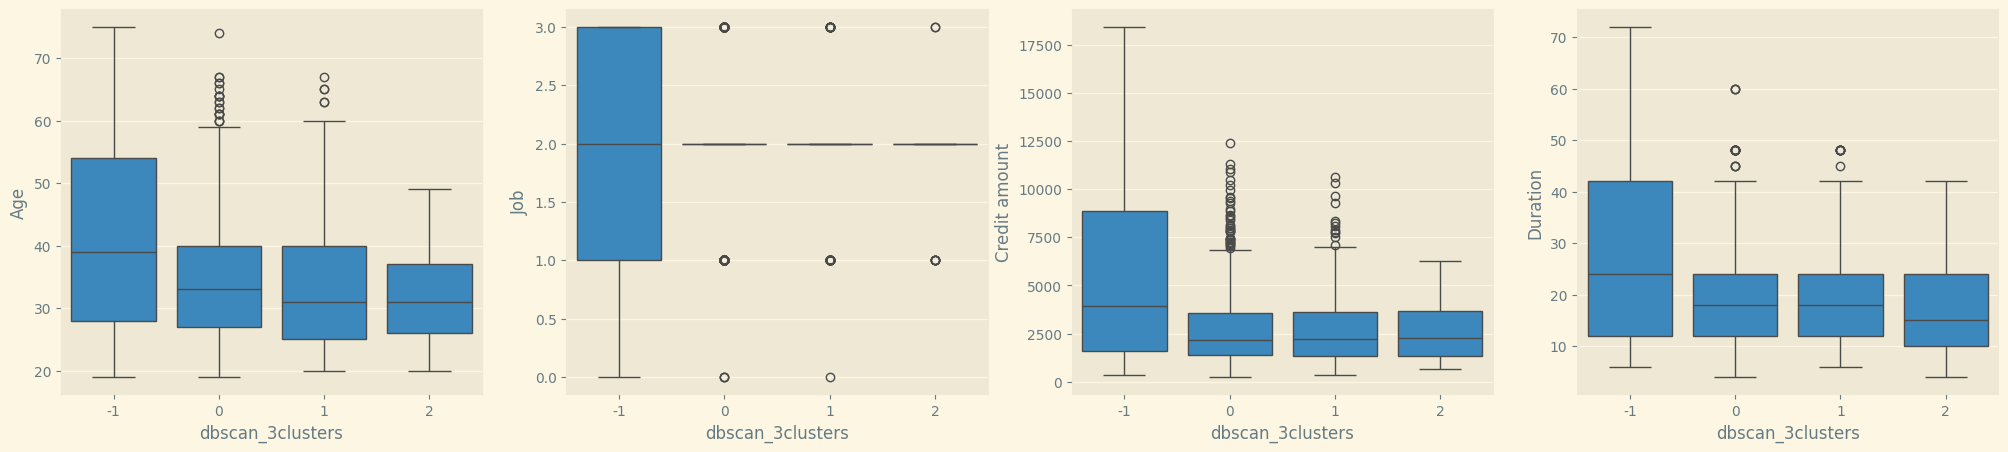

In [54]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(25,5))
sns.boxplot(ax=ax0, data=df, x='dbscan_3clusters', y='Age')
sns.boxplot(ax=ax1, data=df, x='dbscan_3clusters', y='Job')
sns.boxplot(ax=ax2, data=df, x='dbscan_3clusters', y='Credit amount')
sns.boxplot(ax=ax3, data=df, x='dbscan_3clusters', y='Duration')
plt.show()

Видим, что на kmeans хорошо выделяется 1-й кластер по Job, Credit amount, Duration. Hierarhical по этим же данным выделил 0-й кластер.
На DBScan явных зависимостей по этим признакам не обнаружено, возможно, нужно искать в категориальных признаках.